# Signals, Noise, and Filters

In [11]:
%pylab inline
%config InlineBackend.figure_format='svg'
rcParams['figure.figsize'] = (10,6)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import math

Populating the interactive namespace from numpy and matplotlib


## Motivation

In [12]:
data = genfromtxt("wiimote_activity.log", dtype=None, delimiter=",", names=True)

OSError: wiimote_activity.log not found.

In [3]:
data

array([(18580.835, 511, 512, 614), (18580.84 , 511, 512, 614),
       (18580.845, 511, 512, 614), ..., (18622.311, 511, 512, 614),
       (18622.315, 511, 512, 614), (18622.32 , 511, 512, 612)],
      dtype=[('Timestamp', '<f8'), ('X', '<i8'), ('Y', '<i8'), ('Z', '<i8')])

In [4]:
len(data)

8199

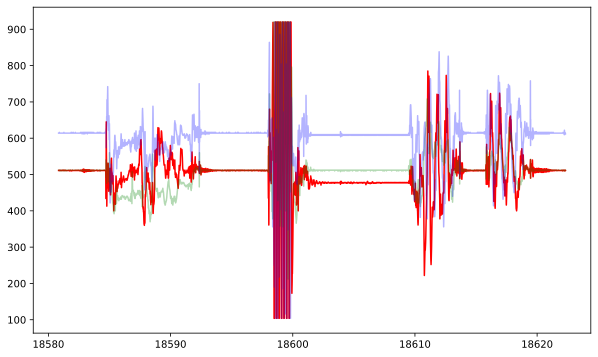

In [5]:
ts, x, y, z = data["Timestamp"], data["X"], data["Y"], data["Z"]
plot(ts, x, 'red', alpha=1)
plot(ts, y, 'green', alpha=0.3)
plot(ts, z, 'blue', alpha=0.3)

What happened here? 

- What can we guess by looking at the graph?
- What types of activities might we want to identify?
- How can we detect, extract, transform, and interpret interesting sensor data?

## Signals

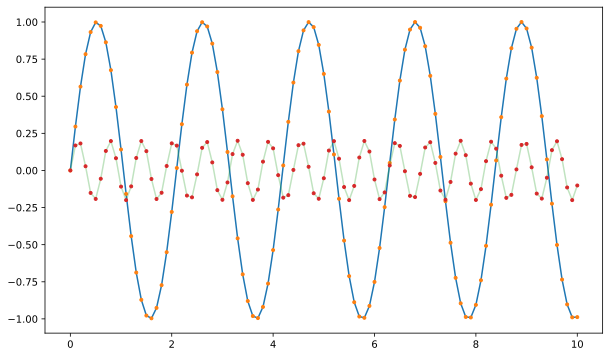

In [6]:
x = linspace(0, 10, 101) # 101 samples from 0 to 10
signal = sin(3*x)
signal2 = sin(10*x)*0.2
plot(x,signal)
plot(x,signal, '.')
plot(x,signal2, alpha=0.3)
plot(x,signal2, '.')

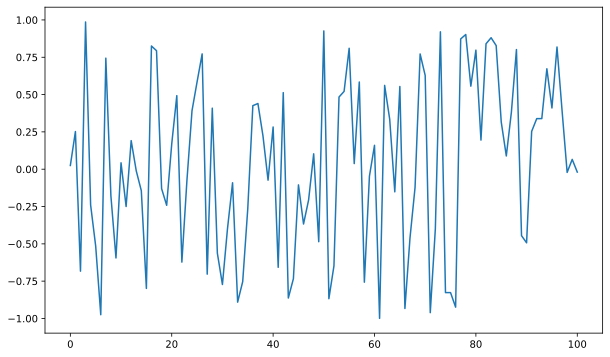

In [7]:
noise = (random.random(101) - 0.5) * 2
plot(noise);

In [8]:
mean(noise)

0.03396065432509233

In [9]:
std(noise)

0.5761577930454321

In [13]:
noisy_signal = signal + (noise * 0.5) # signal-to-noise ratio (SNR) = 2:1 = 3 dB
plot(noisy_signal);

NameError: name 'signal' is not defined

## Frequency, Amplitude, Sampling Rate and Nyquist Theorem

* Frequency
    * SI Unit is Hertz (Hz)
    * Commonly abbreviated as *f*
    * Mathematical representation: \begin{equation*}f=\frac{occurrences}{time}\end{equation*}
    * Basic SI Unit: \begin{equation*}s^{-1}\end{equation*}
    * Shows, how often a repeating event occurs per unit of time

In [11]:
def change_frequency(frequency=1, samples=1001):    
    example_signal = sin(linspace(0, math.pi * 2, samples) * frequency) 
    
    plot(example_signal)
    scatter(range(samples), example_signal)
    
y = interactive(change_frequency, frequency=(1, 25), samples=(1, 1001))

display(y)

interactive(children=(IntSlider(value=1, description='frequency', max=25, min=1), IntSlider(value=1001, descri…

### Amplitude
* Peak
* Peak to Peak
* etc.

### Sampling Rate
    * Measures, how many samples (data points) per second are captured
\begin{equation*}SamplingRate=\frac{samples}{seconds}\end{equation*}

### Nyquist-Shannon Theorem

You use a signals maximum frequency more than doubled as the sampling rate, in order to fully and lossless reconstruct the signal.

Check out this link for an interactive visualization of the relationship of the sampling rate and quality of signal reconstruction: 
https://resources.nerdfirst.net/sampling

## Filtering

### Moving Average Filter

In [12]:
def moving_average(samples, width=10):
    filtered_signal = []
    for i in range(len(samples)):
        filtered_signal.append(sum(samples[i-width:i]/width)) # for real-time filtering
        #filtered_signal.append(sum(samples[i-width//2:i+width//2+1]/width))  # for post-hoc filtering
    return filtered_signal

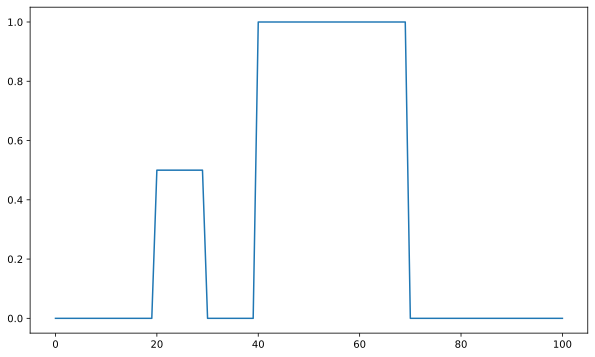

In [13]:
rapid_change=zeros(101)
rapid_change[40:70] = 1
rapid_change[20:30] = 0.5
plot(rapid_change);
# plot(moving_average(rapid_change, width=5));

In [10]:
plot(noisy_signal);
plot(moving_average(noisy_signal, width=5));

NameError: name 'noisy_signal' is not defined

In [15]:
# further reading: weighted, adaptive moving average

### Convolutions and Kernels

## Convolution and Filter Kernels

Discrete Convolution:

Sum:
\begin{equation*}
(f * g)[t] = \sum_{m=-\infty}^\infty f[m]g[t - m]
\end{equation*}

Integral:
\begin{equation*}
\int_{-\infty}^\infty f(\tau)g(t-\tau)  d\tau
\end{equation*}

See numpy documentation for convolve function: https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.convolve.html

* Modes:
    * full
    * same
    * valid

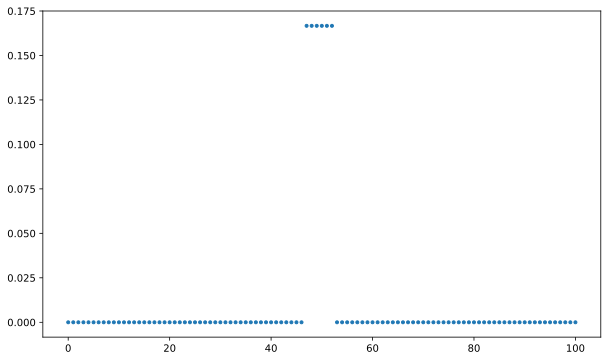

In [16]:
kernel_avg = zeros(101)
for i in range(47,53):
    kernel_avg[i] = 1.0 / 6
plot(kernel_avg, ".");

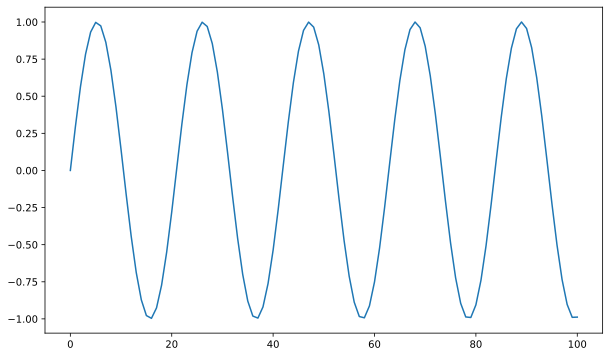

In [17]:
plot(signal)

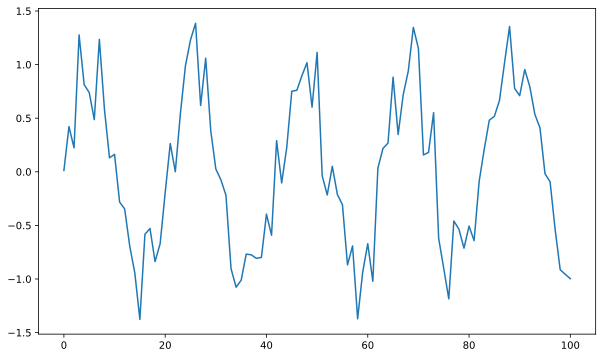

In [18]:
plot(noisy_signal)

In [5]:
filtered_signal = convolve(noisy_signal, kernel_avg, mode='same')

NameError: name 'noisy_signal' is not defined

In [4]:
plot(filtered_signal)
plot(noisy_signal)

NameError: name 'filtered_signal' is not defined

### Calculation Method (Full)

$f$: the signal

$g$: the kernel


$$\begin{equation*}
(f * g)[t] = \sum_{m=-\infty}^\infty f[m]g[t - m]
\end{equation*}$$

Example of numpy.convole documentation: https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.convolve.html


Let's perform the full 1D convolution of $$ [1, 2, 3] \circledast [0, 1, 0.5] $$ (therefore we require zero-padding)

We will use a stride $ S = 1 $ for our convolution.
Therefore, for each step we move the kernel one step further.

The input signal's size $ W = 3 * 1 $, because the vector $ [1, 2, 3] $ is $ 3x1 $.
The kernel's size $ F = 3 $, because the vector $ [0, 1, 0.5] $ contains three columns.
The zero-padding's size $ P = 2 $, because we need two additional zero's on each end of the signal, in order to perform this particular convolution.  

We use the formula: $$ \frac{W - F + 2P}{S}+1 $$
to determine the size of the output of the convolution.
In this case, the size $$ \frac{3 - 3 + 2 * 2}{1}+1 = 5 $$ 

In order to calculate the convolution, we slide the kernel $ [0, 1, 0.5] $ from left to right of
$\begin{pmatrix} 0 & 0 & 1 & 2 & 3 & 0 & 0\end{pmatrix} $

For the first step, we, therefore, calculate $ 0.5 * 0 + 1 * 0 + 0 * 1 = 0 $.

Note that the kernel is flipped before applying to the signal.

Due to the stride $ S = 1 $, we slide the kernel one index to the right.

Therefore, we calculate the second value of our convoluted signal as $ 0.5 * 0 + 1 * 1 + 0 * 2 = 1 $.

Sliding the kernel until the end of the singal yields the following result for our convolution:
$$ [0, 1, 2.5, 4, 1.5] $$

Here is an alternative way of calculating this 1D convolution:


$$\begin{pmatrix}
1 & 0 & 0 \\
2 & 1 & 0 \\
3 & 2 & 1 \\
0 & 3 & 2 \\
0 & 0 & 3 
\end{pmatrix}\circledast
\begin{pmatrix}0 \\ 1 \\ 0.5\end{pmatrix}=
\begin{pmatrix}1 \cdot 0 + 0 \cdot 1 + 0 \cdot 0.5 \\
               2 \cdot 0 + 1 \cdot 1 + 0 \cdot 0.5 \\
               3 \cdot 0 + 2 \cdot 1 + 1 \cdot 0.5 \\
               0 \cdot 0 + 3 \cdot 1 + 2 \cdot 0.5 \\
               0 \cdot 0 + 0 \cdot 1 + 3 \cdot 0.5
\end{pmatrix}=
\begin{pmatrix}0\\1\\2.5\\4\\1.5\end{pmatrix}$$

### Another Calculation Example

$$\begin{pmatrix}
3 & 0 & 0 \\
5 & 3 & 0 \\
7 & 5 & 3 \\
0 & 7 & 5 \\
0 & 0 & 7 
\end{pmatrix}\circledast
\begin{pmatrix}1 \\ 3 \\ 5\end{pmatrix}=
\begin{pmatrix}3\\14\\37\\46\\35\end{pmatrix}$$

### Further Examples

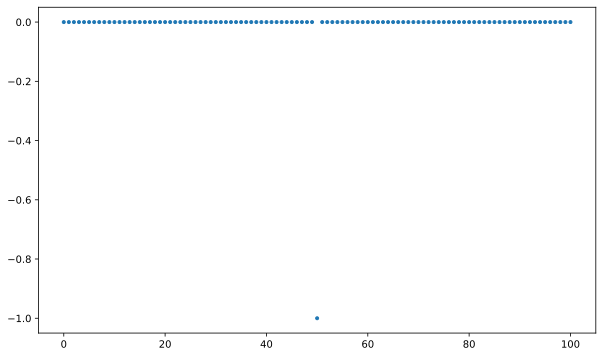

In [21]:
kernel_inv = zeros(101)
kernel_inv[50] = -1
plot(kernel_inv, ".");

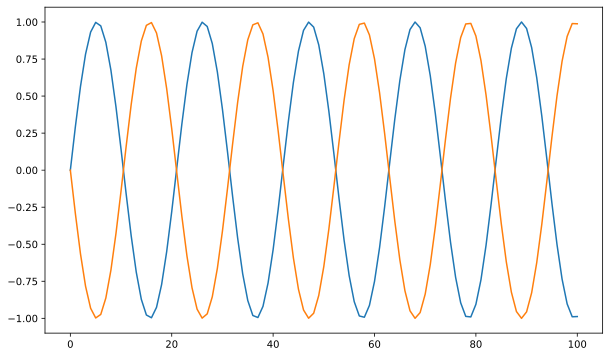

In [22]:
inverted_signal = convolve(signal, kernel_inv, mode='same')
plot(signal)
plot(inverted_signal);

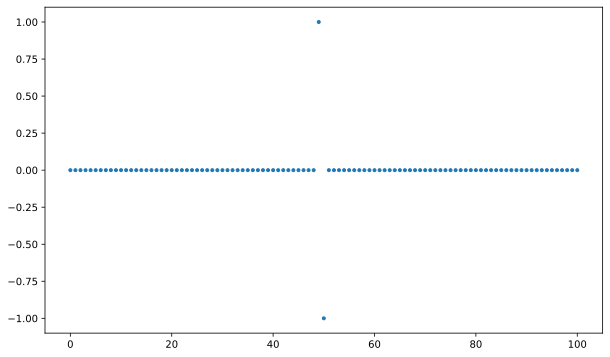

In [23]:
kernel_drv = zeros(101)
kernel_drv[49] = 1
kernel_drv[50] = -1
plot(kernel_drv, ".");

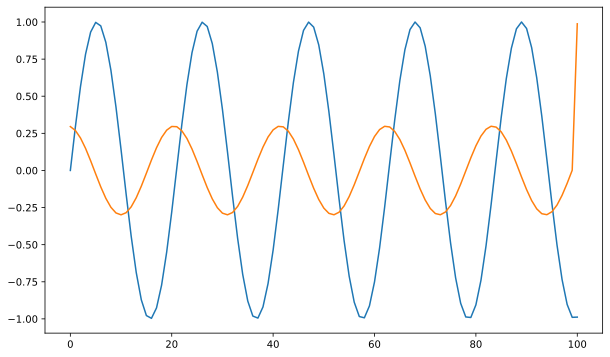

In [24]:
derivative = convolve(signal, kernel_drv, mode='same')
plot(signal)
plot(derivative);

## Distinguishing between signal and noise

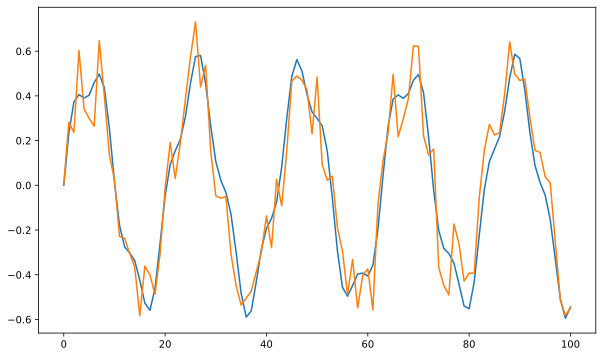

In [25]:
mixed_signal = signal * 0.5 + signal2*0.5
plot(mixed_signal);
plot(mixed_signal + noise * 0.2)

## Convolution Operations on Images (2D Convolution)

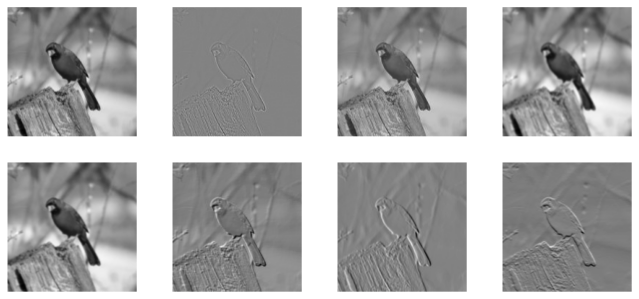

In [26]:
import imageio
from scipy import ndimage
from PIL import Image

def crop_image(img, x, y, size):
    return img[y:y + size, x:x + size]

# change image

data = crop_image(imageio.imread('img/bird.png', as_gray=True, pilmode="L"), 65, 100, 180)

kernels = [
    array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]), # identity
    array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]), # edge detection
    array([[0, -1, 0], [-1, 8, -1], [0, -1, 0]]), # sharpen
    ones((3, 3)) / 9, # box blur
    array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16, # gaussian blur
    array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]]), # emboss
    array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]), # sobel vertical gradient detection
    array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) # sobel horizontal gradient detection
]

fig = figure(figsize(22, 22))

subplots_adjust(left=0.5, bottom=0.7, right=None, top=None, wspace=None, hspace=None)

for i in range(1, len(kernels) + 1):
    img = fig.add_subplot(2, 4, i)
    imshow(ndimage.convolve(data, kernels[i - 1]), cmap='gray')
    axis('off')

### Calculation Method Example (without Zero-Padding)

Remember:
$$ \frac{W - F + 2*P}{S}+1 $$

In the example below, we can see that:

$$ W_{horizontal} = 5 $$
$$ W_{vertical} = 5 $$
$$ F = 3 $$
$$ P = 0 $$
$$ S = 1 $$

$$\begin{pmatrix}
0 & 1 & 1 & 1 & 0 \\
0 & 0 & 1 & 1 & 1 \\
0 & 0 & 0 & 1 & 1 \\
0 & 0 & 0 & 1 & 1 \\
0 & 0 & 1 & 1 & 0 
\end{pmatrix}\circledast
\begin{pmatrix}1 & 0 & 1 \\ 
               0 & 1 & 0 \\ 
               1 & 0 & 1 
\end{pmatrix}=
\begin{pmatrix}
    1 & 4 & 3 \\
    1 & 2 & 4 \\
    1 & 2 & 3
\end{pmatrix}$$

Therefore, our convolution's horizontal and vertical output sizes are 
$$ \frac{5 - 3 + 2*0}{1}+1 = 3 $$ which fits our result ($ 3x3 $ matrix).

We calculate the 2D convolution similarly to the 1D case.

Without zero-padding, we start in the top left corner of the matrix and compute all products of the overlap and sum them up:
$$ 0 * 1 + 1 * 0 + 1 * 1 + 0 * 0 + 0 * 1 + 1 * 0 + 0 * 1 + 0 * 0 + 0 * 1 = 1 $$

Because of stride $ S = 1 $, we have to move one step to the right for the next computation which result is $ 4 $.

Once we reach the end, we move the stride $ S = 1 $ downwards and start from the left again.

We repeat this process until we reached the bottom right corner of the input signal, e.g. the image above.